# Сжатие языковой модели

## Порядок сдачи домашнего

Под каждое домашнее вы создаете отдельную ветку куда вносите все изменения в рамках домашнего. Как только домашнее готово - создаете пулл реквест (обратите внимание что в пулл реквесте должны быть отражены все изменения в рамках домашнего). Ревьювера назначаете из таблицы - https://docs.google.com/spreadsheets/d/1vK6IgEqaqXniUJAQOOspiL_tx3EYTSXW1cUrMHAZFr8/edit?gid=0#gid=0
Перед сдачей проверьте код, напишите тесты. Не забудьте про PEP8, например, с помощью flake8. Задание нужно делать в jupyter notebook.

**Дедлайн - 17 октября 10:00**

В этом домашнем задании вам предстоит изучить и реализовать комбинированный алгоритм для сжатия матриц весов языковой модели, который включает три этапа:
- **Квантизацию**
- **Кодирование Хаффмана**
- **Бит-паккинг**
- **Запись и чтение в файл**

Вам также необходимо будет реализовать обратную процедуру расжатия для восстановления матрицы до её исходного состояния. Пакетом `numpy` пользоваться нельзя.

Для начала сгенерируем нашу матрицу весов. Реализуйте функцию `generate_normal_weights_matrix`, которая будет генерировать матрицу случайных весов, где веса распределены нормально. Вам понадобится функция `random.gauss` для генерации случайных чисел из нормального распределения:

In [112]:
import random

mean = 0.0
stddev = 0.1
random.gauss(mean, stddev)

-0.043345596013387694

```python
weights_matrix = generate_normal_weights_matrix(5, 5)
for row in weights_matrix:
    print(row)
[0.3000485326712691, 0.25965299191334695, -0.06755153631842248, 0.13020487844655038, 0.1143769419370928]
[0.04287032494033407, 0.37860865986969466, -0.21154587156719093, 0.02538857794887883, 0.358874552698265]
[-0.12730102686770312, -0.09250783210681686, -0.31943991155969786, -0.12649930568136855, -0.133368865014227]
[-0.001125940850390421, 0.08131363950833258, -0.12099869191945688, 0.14554258117597563, 0.157276907472140]
[-0.07352639207896368, 0.013629438616873364, -0.11502982664385775, 0.042140678513802377, 0.0980238501942050]
```

In [113]:
def generate_normal_weights_matrix(rows, cols, mean=0.0, stddev=0.1):
    return [[random.gauss(mean, stddev) for _ in range(cols)] for _ in range(rows)]

Для упрощения работы переведем двух мерный массив в одномерный.

In [115]:
weights_matrix = generate_normal_weights_matrix(100, 100, mean, stddev)

In [116]:
weights = [weight for row in weights_matrix for weight in row]

Проверим, что у нас получилось.

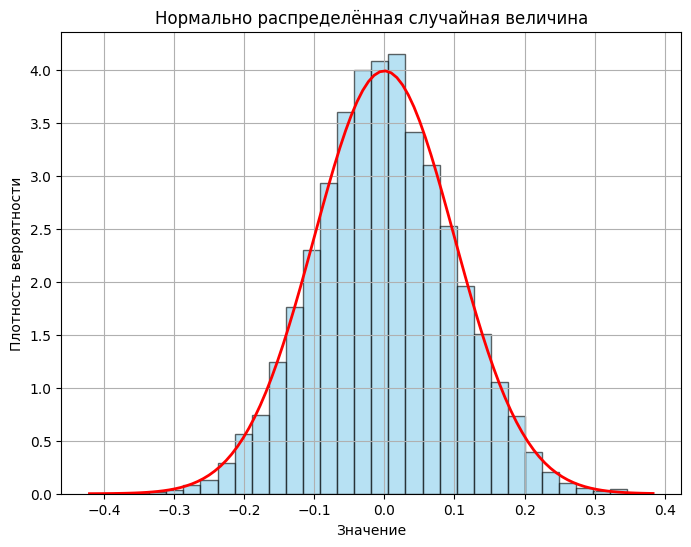

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(weights, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Добавление кривой плотности вероятности
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, stddev)  # Вычисление плотности вероятности
plt.plot(x, p, 'r', linewidth=2)

# Настройки графика
plt.title("Нормально распределённая случайная величина")
plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.grid(True)

# Отображение графика
plt.show()

Приступим к сжатию этой матрицы!

## Квантизация

**Квантизация** — это процесс преобразования данных с высокой точностью (например, с 32-битного представления) в данные с более низкой точностью (например, 8-битное представление) для уменьшения объёма памяти и вычислительных ресурсов. В контексте машинного обучения, квантизация чаще всего применяется к весам нейронных сетей и их активациям для уменьшения размера модели и ускорения работы, особенно при выполнении инференса на мобильных устройствах и встраиваемых системах.


### Цели квантизации:

1.	**Уменьшение объёма памяти:** Квантизация позволяет сократить объём памяти, занимаемый весами и другими параметрами модели, путём представления чисел с меньшей разрядностью.
2.	**Ускорение вычислений:** С помощью квантизации можно использовать специальные процессоры и ускорители (например, процессоры с поддержкой 8-битных вычислений), что увеличивает производительность.
3.	**Снижение энергопотребления:** Более короткие представления данных позволяют сократить энергопотребление при выполнении операций.

### Как работает квантизация?

Квантизация заключается в преобразовании значений с высокой точностью (например, числа с плавающей точкой) в числа с меньшей точностью (например, целые числа). Существует несколько методов квантизации:

1.	**Униформная (равномерная) квантизация:** Простая и часто используемая техника, когда диапазон значений разделяется на равные интервалы (кванты), и каждое значение округляется до ближайшего значения из этого интервала.
2.	**Неравномерная квантизация:** Применяется, когда диапазон значений распределён неравномерно, и поэтому используются интервалы с разной шириной.
3.	**Квантизация во время обучения (quantization-aware training):** Модель обучается с учётом того, что её веса будут квантизированы. Это позволяет лучше подготовить модель к работе в условиях низкой точности.
4.	**Квантизация после обучения (post-training quantization):** Модель сначала обучается с полной точностью, а затем веса и активации квантизируются.

В данном домашнем задании мы рассмотри наиболее простой вариант - **равномерная квантизация**.

### Пример униформной квантизации

Предположим, у нас есть матрица весов, представленная в виде чисел с плавающей точкой, и мы хотим сократить количество бит, используемых для хранения этих значений.

#### Шаг 1: Определение диапазона значений

Для начала определим минимальное и максимальное значение весов, чтобы определить диапазон:

In [118]:
min_value = min(weights)
max_value = max(weights)

print(f"Минимальное значение: {min_value}")
print(f"Максимальное значение: {max_value}")

Минимальное значение: -0.3839578660089528
Максимальное значение: 0.34670974425704965


#### Шаг 2: Определение шага квантизации

Теперь мы определим шаг квантизации, который будет разделять диапазон на равные интервалы. Предположим, что мы хотим использовать 8-битное представление. Это даёт нам $256$ различных значений (так как $8$ бит позволяют хранить $2^8 = 256$ различных чисел).

Шаг квантизации можно вычислить как:


$$\text{step} = \frac{\max - \min}{2^8 - 1}$$


In [128]:
num_levels = 256  # Для 8 бит
step = (max_value - min_value) / (num_levels - 1)
print(f"Шаг квантизации: {step}")

Шаг квантизации: 0.002865363177513735


#### Шаг 3: Применение квантизации

Теперь мы можем преобразовать каждое значение в его ближайший квантизированный уровень:


$$\text{quantized_value} = \text{round} \left( \frac{\text{value} - \min}{\text{step}} \right)$$


In [129]:
quantized_weights = [round((weight - min_value) / step) for weight in weights]

print("Квантизированные веса:")
print(set(quantized_weights))

Квантизированные веса:
{0, 14, 18, 20, 23, 25, 27, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 233, 235, 237

#### Шаг 4: Обратное преобразование (деквантизация)

Чтобы восстановить оригинальные значения весов, необходимо преобразовать квантизированные значения обратно в их исходный диапазон:


$$\text{recovered_value} = \text{quantized_value} \times \text{step} + \min$$


In [130]:
recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]

print("Восстановленные веса:")
print(recovered_weights[:5])

Восстановленные веса:
[0.10315387416838218, -0.14040199592028532, 0.03438515790805252, -0.111748364145148, 0.17765331678373925]


Посчитаем максимальную ошибку

In [131]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.001432614805208926

На практике намного удобнее, когда мы можем контролировать ошибку, поэтому реализуйте методы квантизации и деквантизации, у которых будет параметр максимальной возможной ошибки между значениями для задания `step`.

In [139]:
def quantize_weights(weights, max_error):
    min_value = min(weights)
    max_value = max(weights)

    num_levels = 1  # Для 8 бит
    cur_max_error = max_error + 1
    while cur_max_error > max_error:
        num_levels += 1
        step = (max_value - min_value) / (num_levels - 1)
        quantized_weights = [round((weight - min_value) / step) for weight in weights]
        recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]
        cur_max_error = max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])
    return quantized_weights, step, min_value


def dequantize_weights(quantized_weights, step, min_value):
    recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]
    return recovered_weights

In [140]:
max_error = 0.01
quantized_weights, step, min_value = quantize_weights(weights, max_error)
recovered_weights = dequantize_weights(quantized_weights, step, min_value)

## Кодирование Хаффмана

**Кодирование Хаффмана** — это алгоритм сжатия данных, который используется для минимизации количества бит, необходимых для представления данных. Алгоритм Хаффмана является типом префиксного кодирования, где каждому символу данных назначается уникальная двоичная строка (код), и никакой код не является префиксом другого кода.

Этот метод особенно полезен, когда некоторые символы встречаются чаще других. Хаффмановское кодирование назначает более короткие коды для часто встречающихся символов и более длинные коды для редких символов, что позволяет сжимать данные без потерь.

Основные характеристики кодирования Хаффмана:

- **Префиксный код:** никакой код не является префиксом другого кода, что позволяет однозначно декодировать последовательность.
- **Оптимальность:** алгоритм Хаффмана даёт минимальную длину кодов для символов при известной частоте их появления.
- **Дерево Хаффмана:** строится на основе частот символов, где часто встречающиеся символы находятся ближе к корню дерева.


### Этапы работы алгоритма Хаффмана:

1.	**Подсчёт частот:** На первом шаге подсчитывается, как часто каждый символ встречается в данных.
2.	**Построение дерева Хаффмана:** Используя частоты символов, строится бинарное дерево. Символы с меньшими частотами располагаются дальше от корня дерева, а символы с более высокими частотами — ближе.
3.	**Назначение кодов:** Проходя от корня дерева к каждому листу (символу), алгоритм назначает каждому символу код: левой ветви присваивается “0”, а правой ветви — “1”. Таким образом, для каждого символа формируется уникальная двоичная строка.
4.	**Сжатие данных:** После того как к каждому символу присвоен код, данные можно сжать, заменив символы на соответствующие двоичные коды.
5.	**Декодирование:** Для восстановления исходных данных декодирование выполняется путём чтения двоичной строки и перемещения по дереву Хаффмана от корня до символа, который закодирован.

### Пример работы алгоритма Хаффмана

Рассмотрим, как кодирование Хаффмана может быть применено к строке “ABRACADABRA”.

**1.	Частоты символов:**
Подсчитаем частоты каждого символа в строке:
```python
A: 5
B: 2
R: 2
C: 1
D: 1
```

**2. Построение дерева Хаффмана:**
- Начнем с того, что каждый символ представляется в виде узла дерева с весом, равным частоте появления символа.
- На каждом шаге выбираются два узла с наименьшими частотами и объединяются в новый узел, вес которого равен сумме частот двух выбранных узлов. Этот процесс повторяется до тех пор, пока не будет построено одно дерево.

Строим дерево Хаффмана:
```python
Шаг 1:   C:1  D:1 -> 2 (левое поддерево: C, правое поддерево: D)
Шаг 2:   B:2  R:2 -> 4 (левое поддерево: B, правое поддерево: R)
Шаг 3:   2 (CD)  4 (BR) -> 6
Шаг 4:   A:5  6 (CD, BR) -> 11
```

Окончательное дерево Хаффмана выглядит следующим образом:

```python
      11
     /  \
    A    6
        /  \
      CD    BR
      / \   / \
     C   D B   R
```

**3.	Назначение кодов:**
Теперь присвоим каждому символу код, начиная от корня дерева:
- A: 0
- C: 100
- D: 101
- B: 110
- R: 111

**4. Сжатие строки:**
Используя полученные коды, мы можем закодировать строку “ABRACADABRA”:
```python
A -> 0
B -> 110
R -> 111
A -> 0
C -> 100
A -> 0
D -> 101
A -> 0
B -> 110
R -> 111
A -> 0
```

Закодированная строка: 0110111001000101101110

Реализуйте методы `huffman_encode` и `huffman_decode` для кодирования и декодирования с помощью алгоритма Хаффмана.

In [309]:
from collections import defaultdict


class Node:
    def __init__(self, freq, left=None, right=None, code=None):
        self.freq = freq

        self.left = left

        self.right = right

        self.code = code


def count_freqs(weights):
    d = defaultdict(int)
    for ch in weights:
        d[ch] += 1
    return d


def create_tree(freqs):
    tree = {}
    for char, freq in freqs.items():
        tree[char] = Node(freq)
    for i in range(len(freqs.keys()) - 1):
        cur_nodes = sorted(tree.items(), key=lambda item: item[1].freq)[2 * i:2 * i + 2]
        new_node_name = ' '.join([str(cur_nodes[0][0]), str(cur_nodes[1][0])])
        new_node_freq = cur_nodes[0][1].freq + cur_nodes[1][1].freq
        tree[new_node_name] = Node(new_node_freq, cur_nodes[0][0], cur_nodes[1][0], None)
    root = max(tree.items(), key=lambda item: item[1].freq)[0]
    tree[root].code = ''
    walk_tree(root, tree)
    return tree


def create_huff_dict(freqs, tree):
    huff_dict = {}
    for char in freqs.keys():
        huff_dict[char] = tree[char].code
    return huff_dict


def walk_tree(key, tree):
    if tree[key].left != None:
        tree[tree[key].left].code = tree[key].code + '0'
        walk_tree(tree[key].left, tree)
    if tree[key].right != None:
        tree[tree[key].right].code = tree[key].code + '1'
        walk_tree(tree[key].right, tree)


def huffman_encode(weights):
    freqs = count_freqs(weights)
    tree = create_tree(freqs)
    huff_dict = create_huff_dict(freqs, tree)
    encoded_data = ''.join([huff_dict[char] for char in weights])
    return encoded_data, huff_dict


def huffman_decode(encoded_data, huff_dict):
    inv_huff_dict = {v: k for k, v in huff_dict.items()}
    buf = []
    l, r = 0, 0
    for r in range(len(encoded_data) + 1):
        if encoded_data[l:r] in inv_huff_dict.keys():
            char = inv_huff_dict[encoded_data[l:r]]
            buf.append(char)
            l = r
    if type(buf[0]) == str:
        buf = ''.join(buf)
    return buf


data = "ABRACADABRA"
encoded_data, huff_dict = huffman_encode(data)
print(f"Закодированные данные: {encoded_data}")
# Закодированные данные: 01101001110011110110100

decoded_data = huffman_decode(encoded_data, huff_dict)
print(f"Декодированные данные: {decoded_data}")
# Декодированные данные: ABRACADABRA

Закодированные данные: 01101110100010101101110
Декодированные данные: ABRACADABRA


#### Посчитаем Хаффмана на наших квантизированных весах

In [351]:
encoded_data, huffman_dict = huffman_encode(quantized_weights)

In [311]:
print(quantized_weights)

[25, 12, 21, 14, 28, 20, 28, 18, 20, 14, 13, 11, 20, 19, 11, 27, 18, 17, 19, 19, 19, 10, 18, 18, 18, 24, 28, 19, 23, 23, 12, 17, 11, 19, 23, 14, 25, 20, 16, 35, 18, 18, 9, 27, 11, 11, 13, 12, 13, 13, 16, 20, 24, 21, 19, 17, 14, 20, 31, 20, 13, 20, 20, 15, 15, 19, 18, 14, 18, 15, 22, 26, 13, 18, 27, 28, 21, 19, 21, 25, 19, 20, 15, 16, 20, 18, 21, 22, 17, 13, 20, 23, 16, 24, 9, 19, 26, 21, 20, 18, 30, 16, 21, 11, 14, 24, 13, 20, 21, 17, 26, 23, 16, 20, 19, 20, 16, 22, 18, 25, 22, 18, 11, 20, 20, 11, 17, 19, 26, 15, 28, 16, 21, 18, 15, 15, 25, 18, 26, 20, 15, 25, 27, 26, 16, 24, 25, 20, 20, 15, 28, 15, 28, 32, 18, 11, 16, 23, 22, 21, 24, 24, 16, 20, 19, 21, 23, 26, 23, 25, 26, 14, 32, 22, 21, 21, 16, 15, 25, 27, 22, 12, 30, 13, 27, 26, 12, 21, 10, 16, 17, 6, 18, 24, 21, 30, 24, 18, 28, 22, 23, 17, 22, 24, 30, 30, 21, 17, 16, 26, 12, 11, 25, 22, 22, 15, 19, 22, 20, 14, 17, 14, 14, 16, 18, 18, 25, 11, 8, 18, 20, 18, 16, 22, 16, 18, 25, 16, 24, 24, 25, 25, 28, 32, 17, 26, 20, 25, 10, 23, 23,

In [312]:
print(huffman_decode(encoded_data, huffman_dict))

[25, 12, 21, 14, 28, 20, 28, 18, 20, 14, 13, 11, 20, 19, 11, 27, 18, 17, 19, 19, 19, 10, 18, 18, 18, 24, 28, 19, 23, 23, 12, 17, 11, 19, 23, 14, 25, 20, 16, 35, 18, 18, 9, 27, 11, 11, 13, 12, 13, 13, 16, 20, 24, 21, 19, 17, 14, 20, 31, 20, 13, 20, 20, 15, 15, 19, 18, 14, 18, 15, 22, 26, 13, 18, 27, 28, 21, 19, 21, 25, 19, 20, 15, 16, 20, 18, 21, 22, 17, 13, 20, 23, 16, 24, 9, 19, 26, 21, 20, 18, 30, 16, 21, 11, 14, 24, 13, 20, 21, 17, 26, 23, 16, 20, 19, 20, 16, 22, 18, 25, 22, 18, 11, 20, 20, 11, 17, 19, 26, 15, 28, 16, 21, 18, 15, 15, 25, 18, 26, 20, 15, 25, 27, 26, 16, 24, 25, 20, 20, 15, 28, 15, 28, 32, 18, 11, 16, 23, 22, 21, 24, 24, 16, 20, 19, 21, 23, 26, 23, 25, 26, 14, 32, 22, 21, 21, 16, 15, 25, 27, 22, 12, 30, 13, 27, 26, 12, 21, 10, 16, 17, 6, 18, 24, 21, 30, 24, 18, 28, 22, 23, 17, 22, 24, 30, 30, 21, 17, 16, 26, 12, 11, 25, 22, 22, 15, 19, 22, 20, 14, 17, 14, 14, 16, 18, 18, 25, 11, 8, 18, 20, 18, 16, 22, 16, 18, 25, 16, 24, 24, 25, 25, 28, 32, 17, 26, 20, 25, 10, 23, 23,

## Бит пакинг

**Бит-паккинг (bit-packing)** — это техника сжатия данных, при которой несколько чисел или символов, представленных в виде бит, “упаковываются” в одно или несколько целых чисел (байтов или слов) с целью минимизировать занимаемую память. Этот метод особенно эффективен, если числа или коды занимают меньше бит, чем стандартный размер ячейки памяти (например, 8 бит для байта или 32 бит для целого числа).


### Основная идея:

Если каждая единица данных (например, число или символ) требует меньше бит, чем стандартная ячейка памяти, можно “упаковать” несколько таких единиц данных в одну ячейку, чтобы избежать потерь памяти на неиспользуемые биты. Это позволяет эффективно использовать пространство памяти и уменьшить общий объём данных.

### Пример использования бит-паккинга после кодирования Хаффмана

После кодирования Хаффмана символы данных преобразуются в коды разной длины (в битах). Например, для часто встречающихся символов коды будут короткими (например, 2 или 3 бита), а для редких символов — длинными (например, 6 или 7 бит). Однако стандартные структуры данных Python (например, массивы байтов) используют 8-битные ячейки памяти, что может привести к неэффективному использованию памяти, если не применить бит-паккинг.

### Почему бит-паккинг полезен после кодирования Хаффмана?

После кодирования Хаффмана мы получаем строку из 0 и 1 разной длины для каждого символа. Например:
```python
A -> 0
B -> 110
C -> 1001
```

Закодированная строка после Хаффмана может выглядеть так: 011011001. Если мы будем хранить эту строку побитно в стандартных байтах, это может занять больше места, чем нужно, так как каждый символ по умолчанию занимает 8 бит. Однако с помощью бит-паккинга можно эффективно “упаковать” эти коды в минимально возможное количество байтов.

### Пример

Предположим, у нас есть коды:

```python
A -> 0 (1 бит)
B -> 110 (3 бита)
C -> 1001 (4 бита)
```

После кодирования строки “AABAC”, мы получаем последовательность бит: 0110110011001. Данная строка может быть запакована в 2 байта:
- В первом байте хранится значение 01101101 (первые 8 бит).
- Во втором байте хранится значение 10011000 (оставшиеся 5 бит и заполненные нулями).

Реализуйте функцию `bit_packing`, которая упаковывает входную битовую строку в набор байт.

```python
encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
Упакованные данные: b'l\xc8'
print(f"Длина упакованных данных: {len(packed_data)} байт")
Длина упакованных данных: 2 байт
```

In [261]:
def bit_packing(bit_string):
    padding = 8 - len(bit_string) % 8
    if padding < 8:
        padded_string = ''.join([bit_string, '0' * padding])
    buf = []
    for i in range(0, len(padded_string), 8):
        packed = int(padded_string[i:i + 8], 2).to_bytes(1, byteorder='big')
        buf.append(packed)
    return b''.join(byte for byte in buf)

In [366]:
encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
# Упакованные данные: b'l\xc8'
print(f"Длина упакованных данных: {len(packed_data)} байт")
# Длина упакованных данных: 2 байт

Упакованные данные: b'l\xc8'
Длина упакованных данных: 2 байт


Реализуйте функцию `bit_unpacking`, которая распаковывет набор байт в битовую строку.
```python
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")
Распакованные данные: 0110110011001000
```

In [328]:
def bit_unpacking(packed_data):
    bits = bin(int.from_bytes(packed_data, byteorder='big'))[2:]
    padding = 8 - len(bits) % 8
    if padding < 8:
        unpacked = ''.join(['0' * padding, bits])
    return unpacked

In [329]:
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")

Распакованные данные: 0110110011001000


#### Теперь запакуем закодированные данные

In [352]:
# перед этим надо запустить код в части с Хаффманом
packed_data = bit_packing(encoded_data)
packed_data

b'\x05aU\xb5~\x95+\xde\xad\x7f}\xdc?\xff\x9d\\\xcc\xab\xaf\x98\x83a\xd9\xff\x8c\xba\xeb\xa2\xa9H\xd3\xce\xb2\xd1[M\xd4N\xf2\xf4\x97\xd3\xd7Vv\x07jF\xfeM\xd3Z\x0cn~o\x89\x19Y\x1d7-\xed\x1b\xdb\x13\xe1?^\xedw\xcfJ\xa3=\x10=\xfa\x80\xb7\xc1\x86\xeaT\x95:\xfdp\xd3\x86q\xbd\x8c\xf6\x07\x93\xac\xe6B\x02\xe5BQoV\x0f\x16\xed\xf3\xc1\x0f\xea\x96\xb91\x04\xcb\x87\xaa\xb0\x99N\x9d+"\x8f\xf0\xac_\xef\xc4\xc7\x84\x19\x80T\xebo\xd0\x1d\x9b\xd9\x9c\xcd\xa8\x8f\xdf1]c\x01\x18w\x86Na\xf7wo\xffo,\x8c\xa2\xb3\x06JwQ\r\x9f\xc5\x99\xe3\xbdC\xbc\xf3/AO`\xaf\xb2[\xafW\xf3\xf3\x8a\xed\xb9\xe6\xd0\xc4)\x07\x0b1\x9a\x93\xec\xc8e\xf3\xe19I\xfbQ\xeb\xe0\x12\xaf\xc0\x01nl\xee\xbb\xf9(\xd4S\x99\xe1\xdc\xe8\x11\x9cIH\xd2\xb3\xaf\xb2\x99\x89\x96:\x0b\xbb\x9b\xd6\xdfO\xb2k\xed\xe3\x98\xe2\x93M\x87\xd6\xf4\x87\x03l\xe6{\xf3\xf8\xdc\xd99\xd3\xc6X\xb7-\xff?\xbaZ\xe4d?fdE\x97\x13\x7f\xb3\xd5S&;\xb67\xf4\x9e3\x17\xdaS\xda\xaa&w\x1e\xb4R7g\xe9y\x97\x99{O<W\xb7fl\xbb\xb9\x08\x15\xefq\xa7\x8c\xdb>0]\xe3\x99\x91t\xb8{_\xed\xd9

## Запись и чтение в файл

Работа с файлами в бинарном режиме в Python позволяет читать и записывать байты вместо текста. Это полезно для работы с бинарными данными, такими как изображения, аудиофайлы, видео, архивы и другие типы файлов, где данные представлены не в текстовом виде, а в виде байтов.

### Открытие файлов в бинарном режиме

Для открытия файла в бинарном режиме используются следующие режимы:

- 'rb' — открыть файл для чтения в бинарном режиме.
- 'wb' — открыть файл для записи в бинарном режиме (при этом файл перезаписывается).
- 'ab' — открыть файл для добавления в бинарном режиме.
- 'rb+' или 'wb+' — открыть файл для чтения и записи в бинарном режиме.

### Кодирование и декодирование
Когда вы открываете файл в бинарном режиме ('wb' или 'rb'), данные в этом файле хранятся и читаются в виде байтов. Символы в строках Python (тип str) не могут быть напрямую записаны в файл, потому что они хранятся в формате Unicode (например, UTF-8, UTF-16), а файлы оперируют байтовыми данными.

- `encode()`: Преобразует строку Unicode в байты с использованием заданной кодировки (по умолчанию обычно UTF-8). Это нужно для записи текста в файл.
- `decode()`: Преобразует байты обратно в строку Unicode, чтобы можно было прочитать текст из файла.

Обратите внимание, что `packed_data` уже байты и их можно без кодирования и декодирования записывать в файл.


### Пример 1: Запись в файл в бинарном режиме

In [203]:
with open('output.bin', 'wb') as f:
    f.write(f"{step:.6f}\n".encode())

### Пример 2: Чтение файла в бинарном режиме

In [204]:
# Открываем файл для чтения в бинарном режиме
with open('output.bin', 'rb') as f:
    step = float(f.readline().strip())
    print(step)

0.019748


Реализуйте функцию `write_to_file` для сохранения матрицы в сжатом формате

In [363]:
import marshal


def write_to_file(filename, packed_data, huffman_dict, step, min_value):
    with open(filename, 'wb') as f:
        f.write(packed_data)
        f.write(b'\n')
        huffman_dict_marsh = marshal.dumps(huffman_dict)
        print(len(huffman_dict_marsh))
        f.write(len(huffman_dict_marsh).to_bytes(4, 'big'))
        f.write(huffman_dict_marsh)

        f.write(step.hex().encode())
        f.write(b'\n')
        f.write(min_value.hex().encode())
        f.write(b'\n')

#### Сохраним в файл сжатую матрицу и параметры для восстановления

In [354]:
compressed_filename = 'compressed_data.bin'

Реализуйте функцию `read_from_file` для чтения матрицы и сохраненной информации необходимой для восстановления матрицы.

In [340]:
def read_from_file(filename):
    return packed_data, huffman_dict, step, min_value

#### Прочитаем файл и восстановим данные

In [356]:
packed_data, huffman_dict, step, min_value = read_from_file(compressed_filename)
unpacked_bits = bit_unpacking(packed_data)
decoded_weights = huffman_decode(unpacked_bits, huffman_dict)
recovered_weights = dequantize_weights(decoded_weights, step, min_value)

#### Посчитаем максимальную ошибку в полученных данных (во время квантизации мы теряли часть данных)

In [357]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.009878359430019669

#### Теперь посчитаем, сколько весят сохранённые данные:

In [358]:
def get_size(filename):
    return os.stat(filename).st_size / (1024 * 1024)

In [359]:
import os

print(f'Размер файла в мегабайтах {get_size(compressed_filename)}')

Размер файла в мегабайтах 0.005772590637207031


Воспользуемся пакетом `struct` для упаковывания флотов в бинарный формат для оригинальных весов.

In [360]:
import struct

original_filename = 'original_data.bin'

with open(original_filename, 'wb') as f:
    for number in weights:
        packed_data = struct.pack('f', number)
        f.write(packed_data)

In [361]:
file_stats = os.stat(original_filename)
print(f'Размер файла в мегабайтах {get_size(original_filename)}')

Размер файла в мегабайтах 0.03814697265625


# Поздравляю, языковые модели сжимать мы теперь умееем!